# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc,confusion_matrix, f1_score
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

import re
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
from sklearn.model_selection import train_test_split, TimeSeriesSplit, validation_curve, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
samplingCount = findMinorClassPoints(filtered_data)
postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=samplingCount)
negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=samplingCount)

filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (164074, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
133704,145137,B004FCNOB6,APJTJOMVQQ7HV,Erika S,0,1,1,1318723200,Great Tea!,I ordered this tea at a restaurant in LA and i...
457885,495086,B00271OPVU,A2VWJ8KF7FG10N,Curious L,0,0,1,1331424000,Such a fantastic Maple Syrup,From time to time I do cleanses that require G...
138836,150669,B0041CIS66,A3MQ6KC1VGUGJJ,granny,1,1,1,1344211200,Addictive!,We love these mango ginger chews. We've tried...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(128581, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

78.3676877506491

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(128581, 10)


1    71470
0    57111
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.
This is the best jerky spice on the market as far as my family is concerned. When our store quit carrying it, we started buying it through Amazon.com. There is no other spice like it. We did try others, but they could not compare to Nesco American Harvest.
purchased for a present. item came promptly and very large bonsai in perfect condition.. very pleased with the transaction and worth the money.. would purchase from this company again..
I was hoping to find good nip for my cats but they don't like this one. I don't know why, they just don't care about it. I'm not sure if it's the nip or the cats. Either way, it gets a 2 from me cause now I have a small bin of dried leaves and that does nothing for either of us.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.
This is the best jerky spice on the market as far as my family is concerned. When our store quit carrying it, we started buying it through Amazon.com. There is no other spice like it. We did try others, but they could not compare to Nesco American Harvest.
purchased for a present. item came promptly and very large bonsai in perfect condition.. very pleased with the transaction and worth the money.. would purchase from this company again..
I was hoping to find good nip for my cats but they don't like this one. I don't know why, they just don't care about it. I'm not sure if it's the nip or the cats. Either way, it gets a 2 from me cause now I have a small bin of dried leaves and that does nothing for either of us.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

purchased for a present. item came promptly and very large bonsai in perfect condition.. very pleased with the transaction and worth the money.. would purchase from this company again..


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

It's a great book with adorable illustrations.  A true classic.  Kids love the poem and there is music that goes with it, if you can find it.  I think it's sung by Carol King.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

purchased for a present item came promptly and very large bonsai in perfect condition very pleased with the transaction and worth the money would purchase from this company again 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 128581/128581 [00:57<00:00, 2246.20it/s]


In [23]:
preprocessed_reviews[1500]

'purchased present item came promptly large bonsai perfect condition pleased transaction worth money would purchase company'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')


100%|██████████| 128581/128581 [00:02<00:00, 48394.10it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [29]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [30]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [34]:
global result_report
result_report = pd.DataFrame(columns=['VECTORIZER-MODEL', 'HYPERPARAMETER', 'F1_SCORE', 'AUC'])

In [35]:
#Sorting according to the time for time-based splitting
final['Time'] = pd.to_datetime(final['Time'], unit='s')
final = final.sort_values(by='Time', ascending=True)

In [36]:
#Splitting the data into 70-30 train test ratio
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'], final['Score'], test_size=0.30)

alpha_range = np.array(sorted([10 ** i for i in range(-11, 3, 1)] 
                              + [2 ** i for i in range(-11, -1, 1)]
                              + [2 ** i for i in range(1, 5, 1)]
                             ))

In [37]:
alpha_range

array([1.0000000e-11, 1.0000000e-10, 1.0000000e-09, 1.0000000e-08,
       1.0000000e-07, 1.0000000e-06, 1.0000000e-05, 1.0000000e-04,
       4.8828125e-04, 9.7656250e-04, 1.0000000e-03, 1.9531250e-03,
       3.9062500e-03, 7.8125000e-03, 1.0000000e-02, 1.5625000e-02,
       3.1250000e-02, 6.2500000e-02, 1.0000000e-01, 1.2500000e-01,
       2.5000000e-01, 1.0000000e+00, 2.0000000e+00, 4.0000000e+00,
       8.0000000e+00, 1.0000000e+01, 1.6000000e+01, 1.0000000e+02])

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [38]:
#Applying BoW Vectorizer on Train and Test Set
bow_model = CountVectorizer(min_df=0.01, ngram_range=(1,2))
bow_model.fit(x_train)

x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

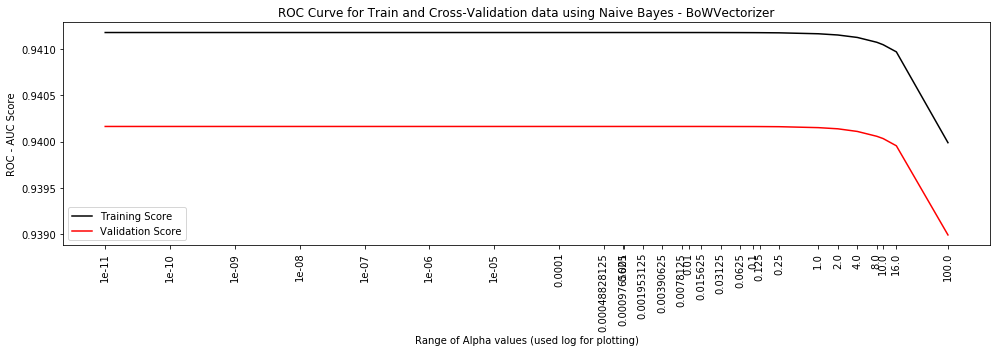

In [39]:
# Applying MultinomialNaiveBayes to Alpha_ranges using GridSearch CV=10
mnb = MultinomialNB()
parameters = {'alpha': alpha_range}
clf = GridSearchCV(mnb, parameters, cv=10, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(x_train_bow, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']
std_train_score = clf.cv_results_['std_train_score']
std_test_score = clf.cv_results_['std_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(alpha_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Naive Bayes - BoWVectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal ALPHA: 0.001953125 with AUC: 93.71%


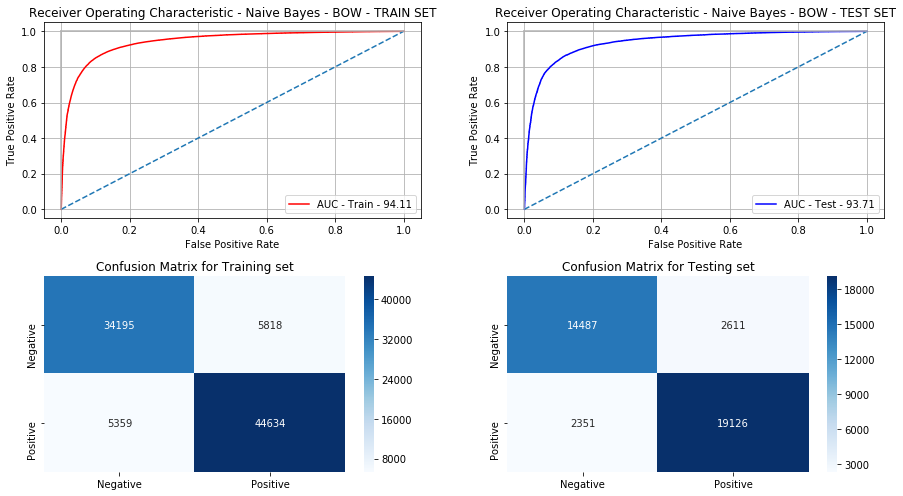

In [40]:
optimal_alpha = alpha_range[mean_test_score.argmax()]

clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(x_train_bow, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_bow)
pred_test = clf.predict(x_test_bow)
pred_proba_train = clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal ALPHA: {} with AUC: {:.2f}%".format(optimal_alpha, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'Bag of Words(BoW)',
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Naive Bayes - BOW - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Naive Bayes - BOW - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [41]:
bow_features = bow_model.get_feature_names()
log_prob_features = clf.feature_log_prob_
feature_df = pd.DataFrame(log_prob_features, columns = bow_features)
feature_prob = feature_df.T

feature_prob = feature_prob[1].sort_values(ascending = False)[0:10]
feature_prob

not       -3.363666
great     -4.036306
good      -4.120054
like      -4.170635
love      -4.506269
coffee    -4.513264
one       -4.520242
taste     -4.549469
tea       -4.589863
product   -4.627020
Name: 1, dtype: float64

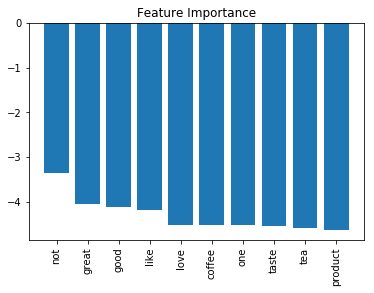

In [42]:
# Create plot
plt.figure()
plt.title("Feature Importance")
# Add bars
plt.bar(range(10), feature_prob)
# Add feature names as x-axis labels
plt.xticks(range(10), feature_prob.index, rotation=90)
plt.show()

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [43]:
bow_features = bow_model.get_feature_names()
log_prob_features = clf.feature_log_prob_
feature_df = pd.DataFrame(log_prob_features, columns = bow_features)
feature_prob = feature_df.T

feature_prob = feature_prob[0].sort_values(ascending = False)[0:10]
feature_prob

not       -2.796320
like      -3.983787
product   -4.242317
taste     -4.251130
would     -4.294658
one       -4.501484
good      -4.626697
no        -4.691514
flavor    -4.737745
coffee    -4.753580
Name: 0, dtype: float64

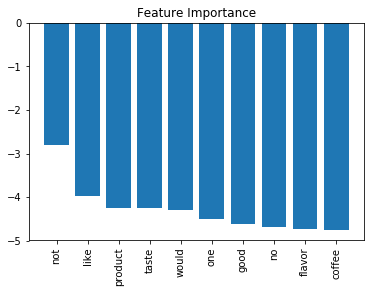

In [44]:
# Create plot
plt.figure()
plt.title("Feature Importance")
# Add bars
plt.bar(range(10), feature_prob)
# Add feature names as x-axis labels
plt.xticks(range(10), feature_prob.index, rotation=90)
plt.show()

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [45]:
#Applying TF-IDF Vectorizer on Train and Test Set
tfidf_model = TfidfVectorizer(min_df = 0.01, ngram_range=(1,2))
tfidf_model.fit(x_train)

x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

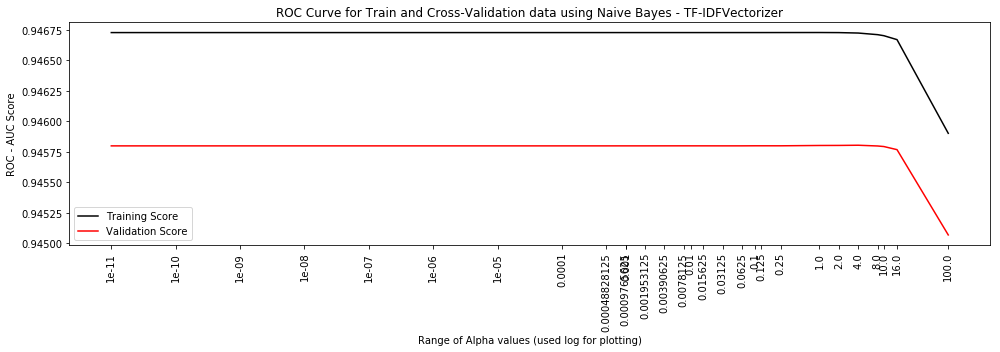

In [46]:
# Applying MultinomialNaiveBayes to Alpha_ranges using GridSearch CV=10
mnb = MultinomialNB()
parameters = {'alpha': alpha_range}
clf = GridSearchCV(mnb, parameters, cv=10, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(x_train_tfidf, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']
std_train_score = clf.cv_results_['std_train_score']
std_test_score = clf.cv_results_['std_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(alpha_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Naive Bayes - TF-IDFVectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal ALPHA: 4.0 with AUC: 94.34%


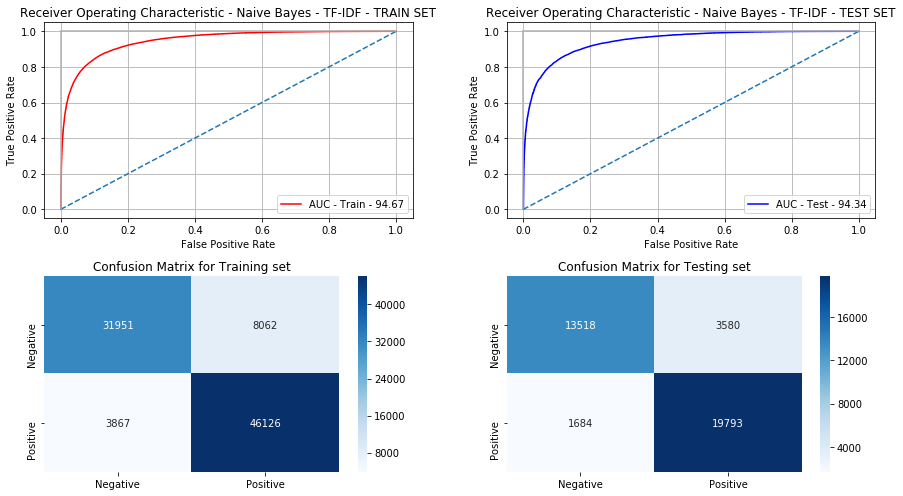

In [47]:
optimal_alpha = alpha_range[mean_test_score.argmax()]

clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(x_train_tfidf, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_tfidf)
pred_test = clf.predict(x_test_tfidf)
pred_proba_train = clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal ALPHA: {} with AUC: {:.2f}%".format(optimal_alpha, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'TF-IDF',
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for train dataset
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Naive Bayes - TF-IDF - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test dataset
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Naive Bayes - TF-IDF - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.grid()

#Plotting the confusion matrix for train dataset
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test dataset
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [48]:
tfidf_features = tfidf_model.get_feature_names()
log_prob_features = clf.feature_log_prob_
feature_df = pd.DataFrame(log_prob_features, columns = tfidf_features)
feature_prob = feature_df.T

feature_prob = feature_prob[1].sort_values(ascending = False)[0:10]
feature_prob

great     -4.312220
not       -4.414387
good      -4.534866
love      -4.658164
coffee    -4.684563
tea       -4.747270
like      -4.811070
best      -4.880733
product   -4.950402
flavor    -4.993214
Name: 1, dtype: float64

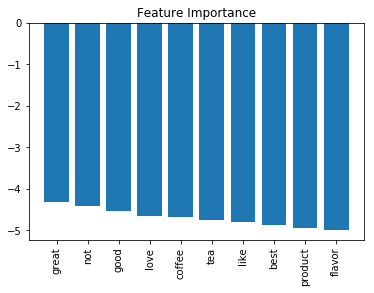

In [49]:
# Create plot
plt.figure()
plt.title("Feature Importance")
# Add bars
plt.bar(range(10), feature_prob)
# Add feature names as x-axis labels
plt.xticks(range(10), feature_prob.index, rotation=90)
plt.show()

### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [50]:
tfidf_features = tfidf_model.get_feature_names()
log_prob_features = clf.feature_log_prob_
feature_df = pd.DataFrame(log_prob_features, columns = tfidf_features)
feature_prob = feature_df.T

feature_prob = feature_prob[0].sort_values(ascending = False)[0:10]
feature_prob

not       -3.723655
like      -4.571474
product   -4.641482
taste     -4.676342
would     -4.768513
one       -4.975348
coffee    -4.978162
no        -5.019666
flavor    -5.070624
good      -5.107681
Name: 0, dtype: float64

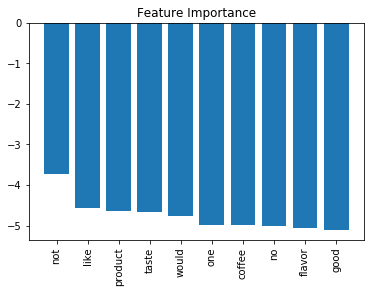

In [51]:
# Create plot
plt.figure()
plt.title("Feature Importance")
# Add bars
plt.bar(range(10), feature_prob)
# Add feature names as x-axis labels
plt.xticks(range(10), feature_prob.index, rotation=90)
plt.show()

# [6] Conclusions

In [52]:
result_report

,VECTORIZER-MODEL,HYPERPARAMETER,F1_SCORE,AUC
0,Bag of Words(BoW),0.001953,0.885176,0.937106
1,TF-IDF,4.000000,0.882631,0.943427


**Final Thoughts** 
1. As we can see, Vectorizing the amazon fine food reviews dataset with Bag of words or TFIDF, we get a similar  AUC value as well as F1 score. _Looking at the results above we can infer that, We can use any vectorizer with Naive Bayes for amazon fine food reviews dataset. Though I think that, TFIDF is performing slightly well.**_
2. We have used Multinomial Naive Bayes as the data consists of Multinomial distribution. And also, Multinomial Naive Bayes works well for the data which can be easily converted to counts such as word counts in text. 